In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def g(x, sigma=1):
    """Gaussian function
    """
    return np.exp(- 0.5 * (x / sigma)**2)

def dg(x, sigma=1):
    return - x * np.exp(-(x/sigma)**2) / sigma**2

class TripleWellPotential:
    def __init__(self, beta, *argv):
        self.beta = beta
        self.dim = 2
        
    def V(self, X):
        # left and right minima
        u1 = g(X[1], 0.4) * (g(X[0] - 1, 0.3) + g(X[0] + 1, 0.3))
        # saddle points on paths
        u2 = g(X[0], 0.4) * (0.5 * g(X[1] - 1.2, 0.3) + g(X[1], 0.3))
        # barrier
        u3 = g(X[0], 0.4) * g(X[1]-0.5, 0.2)
       #upper path
        p1 = g(X[0]**2 + (X[1] - 1/3)**2 - 1.0, 0.5) / (1 + np.exp(4*(0.3-X[1])))    
        # lower path
        p2 = g(X[1], 0.2) * g(X[0], 0.8)   
        
        b1 = np.exp(5.0 *(-0.6 - X[1]))

        V = - 1.2 * u1 + 0.5 * u2 + 2 * u3 - p1 - p2 + b1 + 0.1 * (X[0] ** 2) + 0.1 * (X[1]** 2)
        return V
        
    def gradV(self, X):
        
        u1_dx = g(X[1], 0.4) * (dg(X[0] - 1, 0.3) + dg(X[0] + 1, 0.3))
        u1_dy = dg(X[1], 0.4) * (g(X[0] - 1, 0.3) + g(X[0] + 1, 0.3))
        
        u2_dx = dg(X[0], 0.4) * (0.8 * g(X[1] - 1.2, 0.3) + g(X[1], 0.3))
        u2_dy = g(X[0], 0.4) * (0.8 * dg(X[1] - 1.2, 0.3) + dg(X[1], 0.3))
        
        u3_dx = dg(X[0], 0.4) * g(X[1]-0.5, 0.2)
        u3_dy = g(X[0], 0.4) * dg(X[1]-0.5, 0.2)
        
        p1_dx = 2 * X[0] * dg(X[0]**2 + (X[1] - 1/3)**2 - 1.0, 0.5) / (1 + np.exp(4*(0.3-X[1])))

        p1_dy = 2 * (X[1] - 1/3) * dg(X[0]**2 + (X[1] - 1/3)**2 - 1.0, 0.5) / (1 + np.exp(4*(0.3-X[1]))) \
                + g(X[0]**2 + (X[1] - 1/3)**2 - 1.0, 0.5) \
                * 4 / (1 + np.exp(4*(0.3-X[1])))**2 * np.exp(4*(0.3-X[1]))

        p2_dx = g(X[1], 0.2) * dg(X[0], 0.8)
        p2_dy = dg(X[1], 0.2) * g(X[0], 0.8)
        
        b1_dx = 0
        b1_dy = -5.0 * np.exp(5.0 *(-0.6 - X[1]))

        V_dx = -1.2 * u1_dx + 0.5 * u2_dx + 2 * u3_dx - p1_dx - p2_dx + 0.2 * (X[0])       
        V_dy = -1.2 * u1_dy + 0.5 * u2_dy + 2 * u3_dy - p1_dy - p2_dy + b1_dy + 0.2 * (X[1])
        
        return np.array((V_dx, V_dy))
    
    def index_of_well(self,x, tol=0.2):
        w0 = np.array([-1,0])                
        w1 = np.array([1,0])                
        d0 = np.linalg.norm(x-w0, axis=1)
        d1 = np.linalg.norm(x-w1, axis=1)
        idx_0 = d0 < tol   
        idx_1 = d1 < tol   
        idx_vec = np.full(x.shape[0], -1, dtype=int)
        idx_vec[idx_0] = 0
        idx_vec[idx_1] = 1
        return idx_vec    

min and max values of potential: (-1.7524, 2.0157)


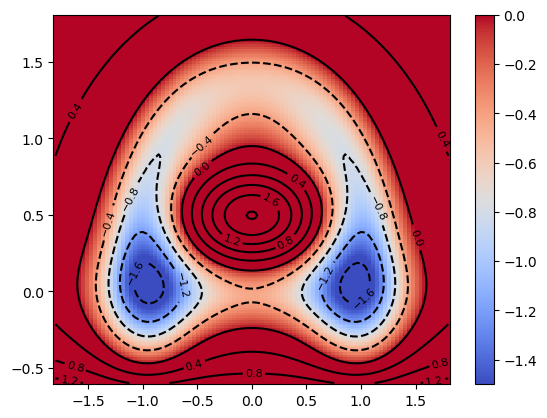

In [3]:
nx = 100
ny = 150
x_domain = [-1.8, 1.8]
y_domain = [-0.6, 1.8]
v_min_max = [-1.5, 0]
dx = (x_domain[1] - x_domain[0]) / nx
dy = (y_domain[1] - y_domain[0]) / ny

gridx = np.linspace(x_domain[0], x_domain[1], nx)
gridy = np.linspace(y_domain[0], y_domain[1], ny)
x_plot = np.outer(gridx, np.ones(ny)) 
y_plot = np.outer(gridy, np.ones(nx)).T 

x2d = np.concatenate((x_plot.reshape(nx * ny, 1), y_plot.reshape(nx * ny, 1)), axis=1)

beta = 12
pot = TripleWellPotential(beta)

pot_on_grid = np.array([pot.V(x) for x in x2d]).reshape(nx, ny)
print ( "min and max values of potential: (%.4f, %.4f)" % (pot_on_grid.min(), pot_on_grid.max()) )

fig, ax = plt.subplots()

im = ax.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm',shading='auto', vmin=v_min_max[0], vmax=v_min_max[1])
contours = ax.contour(x_plot, y_plot, pot_on_grid, 10, colors='black')
ax.clabel(contours, inline=True, fontsize=8)
#        ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))
#        ax.axis('equal')
fig.colorbar(im, ax=ax)


Text(0.5, 1.0, '$y$ along trajectory')

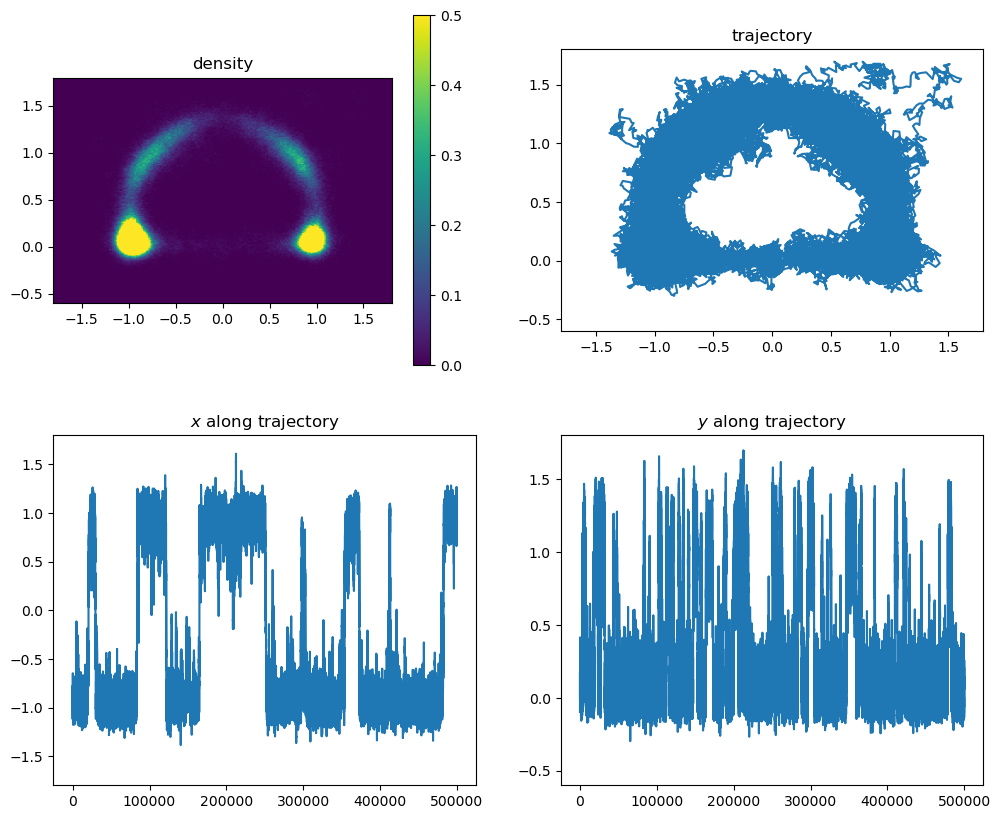

In [5]:
def UnbiasedTraj(pot, X_0, delta_t=1e-3, N=1000, save=1, save_energy=False, seed=0):
    """Simulates an overdamped langevin trajectory with a Euler-Maruyama numerical scheme 

    :param pot: potential object, must have methods for energy gradient and energy evaluation
    :param X_0: Initial position, must be a 2D vector
    :param delta_t: Discretization time step
    :param N: Number of points in the trajectory (the total simulation time is therefore N * delta_t)
    :param save: Integer giving the period (counted in number of steps) at which the trajectory is saved
    :param save_energy: Boolean parameter to save energy along the trajectory

    :return: traj: np.array with ndim = 2 and shape = (N // save + 1, 2)
    :return: Pot_values: np.array with ndim = 2 and shape = (N // save + 1, 1)
    """
    r = np.random.RandomState(seed)
    X = X_0.reshape(2)
    dim = X.shape[0]
    traj = [X]
    if save_energy:
        Pot_values = [pot.V(X)]
    else:
        Pot_values = None
    for i in range(N):
        b = r.normal(size=(dim,))
        X = X - pot.gradV(X) * delta_t + np.sqrt(2 * delta_t/pot.beta) * b
        if i % save==0:
            traj.append(X)
            if save_energy:
                Pot_values.append(pot.V(X)[0])
    return np.array(traj), np.array(Pot_values)

delta_t = 0.005
x_0 = np.array([-1.0,0])
N = 500000
seed = 10
save = 1
density_max=0.5

### Generate the trajectory
trajectory, _ = UnbiasedTraj(pot, x_0, delta_t=delta_t, N=N, save=save, save_energy=False, seed=seed)

### Plot the trajectory 
fig = plt.figure(figsize=(12,10))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

nx = ny = 200
h = np.histogram2d(trajectory[:,0], trajectory[:,1], bins=[nx, ny], range=[[x_domain[0],x_domain[1]],[y_domain[0],y_domain[1]]])[0]
s = sum(sum(h))
im = ax0.imshow(h.T / (s * dx * dy), origin = "lower", \
                #h.T, origin = "lower", \
                extent=[x_domain[0],x_domain[1],y_domain[0], y_domain[1]], \
                cmap="viridis", vmin=0, vmax=density_max)
fig.colorbar(im, ax=ax0)
ax0.set_xlim([x_domain[0], x_domain[1]])
ax0.set_ylim([y_domain[0], y_domain[1]])
ax0.set_title('density')

#ax0.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm_r', shading='auto')
#ax1.scatter(trajectory[:,0], trajectory[:,1], marker='x')
ax1.plot(trajectory[:,0], trajectory[:,1])
ax1.set_xlim([x_domain[0], x_domain[1]])
ax1.set_ylim([y_domain[0], y_domain[1]])
ax1.set_title('trajectory')
ax1.set_aspect('equal')
#ax2.plot()
ax2.plot(range(len(trajectory[:,0])), trajectory[:,0])
ax2.set_ylim([x_domain[0], x_domain[1]])
ax2.set_title(r'$x$ along trajectory')

ax3.plot(range(len(trajectory[:,1])), trajectory[:,1])
ax3.set_ylim([y_domain[0], y_domain[1]])
ax3.set_title(r'$y$ along trajectory')


In total, 11 reactive paths
6 left->right:
 [[ 18904  23380]
 [ 82889  84653]
 [163838 173126]
 [346714 359576]
 [409681 412883]
 [478500 482967]]
5 right->left:
 [[ 27322  32210]
 [121221 122135]
 [250289 252713]
 [372780 373180]
 [413089 413619]]
(45215, 2)


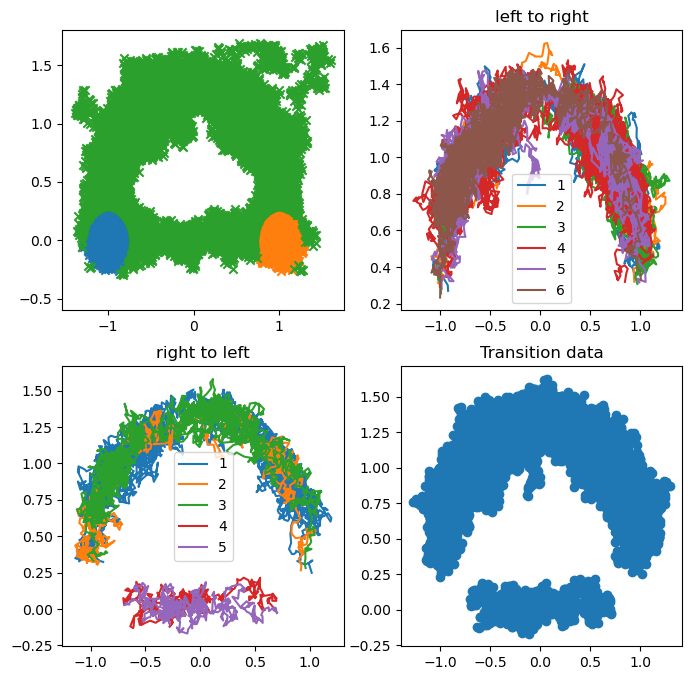

In [6]:
idx_vec = pot.index_of_well(trajectory, tol=0.3)

states_left = trajectory[idx_vec==0]
states_right = trajectory[idx_vec==1]
states_transition = trajectory[idx_vec==-1]

nl = states_left.shape[0]
nr = states_right.shape[0]
nt = states_transition.shape[0]

index_01 = np.where(idx_vec != -1)[0]

l2r = np.where((idx_vec[index_01[:-1]]==0) & (idx_vec[index_01[1:]] ==1))[0]
r2l = np.where((idx_vec[index_01[:-1]]==1) & (idx_vec[index_01[1:]] ==0))[0]

reactive_l2r = np.stack((index_01[l2r], index_01[l2r+1]), axis=1)
reactive_r2l = np.stack((index_01[r2l], index_01[r2l+1]), axis=1)

print ("In total, %d reactive paths" % (l2r.shape[0] + r2l.shape[0]))

print ("%d left->right:\n" % l2r.shape[0], reactive_l2r)

print ("%d right->left:\n" % r2l.shape[0], reactive_r2l)

### Plot the trajectory 
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

ax0.scatter(states_left[:,0], states_left[:,1], marker='x')
ax0.scatter(states_right[:,0], states_right[:,1], marker='x')

ax0.scatter(states_transition[:,0], states_transition[:,1], marker='x')

ax0.set_ylim([y_domain[0], y_domain[1]])

for i in range(l2r.shape[0]):
    i0 = reactive_l2r[i,0]
    i1 = reactive_l2r[i,1]   
    ax1.plot(trajectory[i0:i1,0], trajectory[i0:i1,1], label='%d' % (i+1))
    
ax1.set_title("left to right")

ax1.legend()

for i in range(r2l.shape[0]):
    i0 = reactive_r2l[i,0]
    i1 = reactive_r2l[i,1]   
    ax2.plot(trajectory[i0:i1,0], trajectory[i0:i1,1], label='%d' % (i+1))

ax2.set_title("right to left")
    
ax2.legend()

X1 = np.concatenate([trajectory[reactive_l2r[i,0]:reactive_l2r[i,1],:] for i in range(l2r.shape[0])])
X2 = np.concatenate([trajectory[reactive_r2l[i,0]:reactive_r2l[i,1],:] for i in range(r2l.shape[0])])

X = np.concatenate((X1, X2))
ax3.scatter(X[:,0], X[:,1])
ax3.set_title("Transition data")
print (X.shape)

In [7]:
# a potential function
def V(X):
    return (X[0]**2 - 1)**2 + 1.0 / 0.5 * (X[0]**2 + X[1] - 1)**2

# gradient of potential function 
def gradV(X):
    return np.array(( 4.0 * X[0] * (X[0]**2 - 1.0 + 1.0 / 0.5* (X[0]**2 + X[1] - 1)), 2.0 / 0.5 * (X[0]**2 + X[1] - 1)) )

# function to generate trajectory data using Euler-Maruyama scheme
def sample():
    rng = np.random.default_rng(seed=42)
    X = [-1, 0]
    dim = 2 
    traj = [X]
    beta = 1
    delta_t = 0.001
    save = 10
    N = 100000

    for i in range(N):
        b = rng.normal(size=(dim,))
        X = X - gradV(X) * delta_t + np.sqrt(2 * delta_t/beta) * b
        if i % save==0:
            traj.append(X)

    return np.array(traj)

# generate a 2D trajectory 
trajectory = sample()

print ("shape of trajectory array:", trajectory.shape)
# compute values of potential along the trajectory
v_traj = np.array([V(x) for x in trajectory])

shape of trajectory array: (10001, 2)
